## Initiate Project

In [90]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import os
# import sys
# import inspect

# # Get the current script's directory
# script_path = os.path.abspath(inspect.getfile(inspect.currentframe()))
# script_dir = os.path.dirname(script_path)

# # Navigate to the project root and then into the "scripts" folder
# scripts_path = os.path.abspath(os.path.join(script_dir, "..", "scripts"))

# # Add "scripts" folder to sys.path
# sys.path.append(scripts_path)

# # Now import the function from utils.py
# from scripts.utils import your_function  # Replace with the actual function name


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor


import warnings
warnings.filterwarnings("ignore")

RSEED = 42


In [29]:
# Read data
df_tanzania=pd.read_csv("../data/Train.csv")

In [30]:
# THIS HAS TO GO ONCE WE CAN IMPORT UTILS

# As our target is TZN money, function to have custom format to make the plots more readable. 
def thousands_formatter(x, pos):
    return f'{int(x):,}'

In [31]:
df_tanzania.shape

(4809, 23)

## Evaluate Target 

We will remove outliers for higher expeditures, as we don't have enouogh data to calculate a consistent model. Assume that for higher expeditures, the model can lead to errors. 

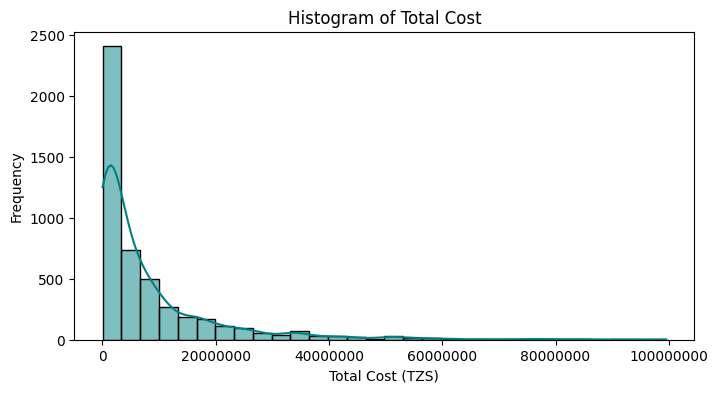

In [32]:
# Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_tanzania["total_cost"], bins=30, kde=True, color = "teal", alpha = 0.5)
plt.title('Histogram of Total Cost')
plt.xlabel('Total Cost (TZS)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain')
plt.show()

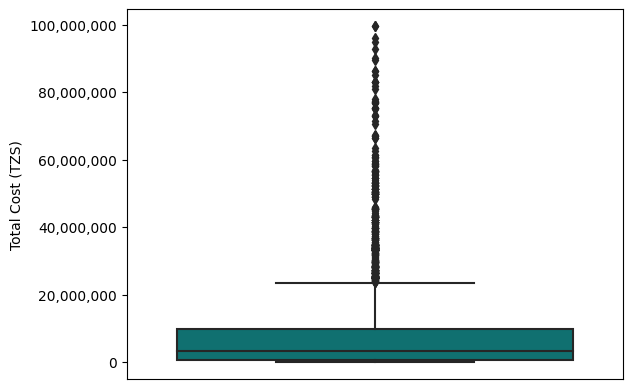

In [33]:
# Plotting the boxplot
sns.boxplot(df_tanzania["total_cost"], color="teal")
plt.xticks([])  # Removes the x-axis ticks

# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZS)")

# Display the plot
plt.show()

In [34]:
# Define function to print the whiskers of a boxplot

def calculate_whiskers(df, column):
    """
    Calculate the lower and upper whiskers for a specified column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to calculate whiskers for.

    Returns:
        tuple: (lower_whisker, upper_whisker)
    """
    # Get descriptive statistics for the column
    stats = df[column].describe()
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1

    # Calculate the lower whisker
    lower_whisker = max(
        df[column][df[column] >= (Q1 - 1.5 * IQR)].min(), 
        df[column].min()
    )
    
    # Calculate the upper whisker
    upper_whisker = min(
        df[column][df[column] <= (Q3 + 1.5 * IQR)].max(), 
        df[column].max()
    )
    
    return lower_whisker, upper_whisker

In [35]:
lower, upper = calculate_whiskers(df_tanzania, "total_cost")
print("Upper Whisker total cost", upper)

Upper Whisker total cost 23635950.0


In [36]:
#Remove outliers
df_tanzania = df_tanzania.query("total_cost <= 23635950.0")

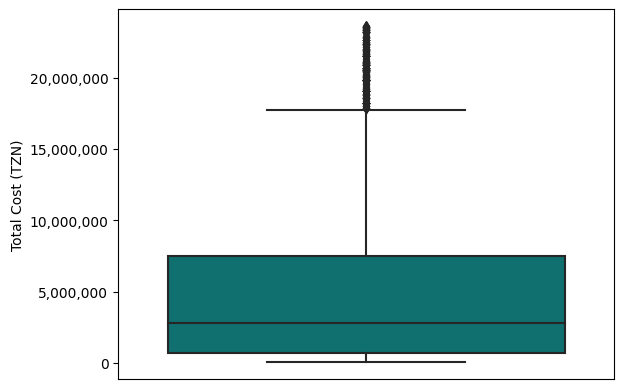

In [39]:
# Plotting the boxplot
sns.boxplot(df_tanzania["total_cost"], color="teal")
plt.xticks([])  # Removes the x-axis ticks

# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZN)")

# Display the plot
plt.show()

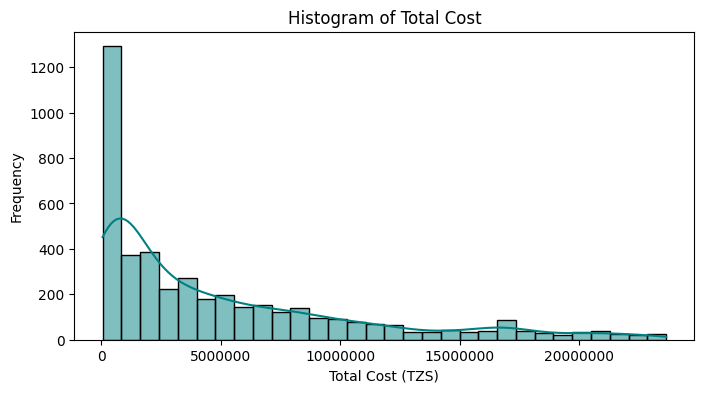

In [40]:
# Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_tanzania["total_cost"], bins=30, kde=True, color = "teal", alpha = 0.5)
plt.title('Histogram of Total Cost')
plt.xlabel('Total Cost (TZS)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain')
plt.show()

## Train-Test Split

In [41]:
# split train-test data. We have dropped:
# "ID" as it is irrelevant for the case and 
# "most_impressing" as it is correlated with "purpose"

X = df_tanzania.drop(['total_cost','ID', "most_impressing", "country"], axis=1)
y = df_tanzania.total_cost

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=RSEED)
# Build new data frame for EDA

df_tanzania_train = X_train.join(y_train)
df_tanzania_test = X_test.join(y_test)

## EDA

In [43]:
df_tanzania_train.columns

Index(['age_group', 'travel_with', 'total_female', 'total_male', 'purpose',
       'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'total_cost'],
      dtype='object')

In [44]:
# Check for empty values. We have them in "total_female", "total_male" and mostly in "travel_with"

df_tanzania_train.isnull().sum()

age_group                  0
travel_with              823
total_female               2
total_male                 3
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
payment_mode               0
first_trip_tz              0
total_cost                 0
dtype: int64

In [45]:
# most of our features are categorical, besides four of them: 
# total_female, total_male, night_mainland, night_zanzibar and the total cost

df_tanzania_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3288 entries, 4428 to 958
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_group              3288 non-null   object 
 1   travel_with            2465 non-null   object 
 2   total_female           3286 non-null   float64
 3   total_male             3285 non-null   float64
 4   purpose                3288 non-null   object 
 5   main_activity          3288 non-null   object 
 6   info_source            3288 non-null   object 
 7   tour_arrangement       3288 non-null   object 
 8   package_transport_int  3288 non-null   object 
 9   package_accomodation   3288 non-null   object 
 10  package_food           3288 non-null   object 
 11  package_transport_tz   3288 non-null   object 
 12  package_sightseeing    3288 non-null   object 
 13  package_guided_tour    3288 non-null   object 
 14  package_insurance      3288 non-null   object 
 15  night_m

In [47]:
# Export unique values for all categorical features to analyze outside of VScode
unique_values = X_train.apply(lambda col: col.unique())
print('unique:',unique_values)
unique_values.to_csv('../data/unique_Value_train_features.csv')

unique: age_group                                        [25-44, 45-64, 65+, 1-24]
travel_with              [Friends/Relatives, Alone, Spouse, nan, Spouse...
total_female             [2.0, 0.0, 1.0, 3.0, 4.0, nan, 5.0, 10.0, 11.0...
total_male               [0.0, 1.0, 2.0, 5.0, 3.0, 4.0, nan, 6.0, 9.0, ...
purpose                  [Meetings and Conference, Other, Leisure and H...
main_activity            [Hunting tourism, business, Wildlife tourism, ...
info_source              [Tanzania Mission Abroad, Travel, agent, tour ...
tour_arrangement                               [Independent, Package Tour]
package_transport_int                                            [No, Yes]
package_accomodation                                             [No, Yes]
package_food                                                     [No, Yes]
package_transport_tz                                             [No, Yes]
package_sightseeing                                              [No, Yes]
package_guided_to

## Some Plots

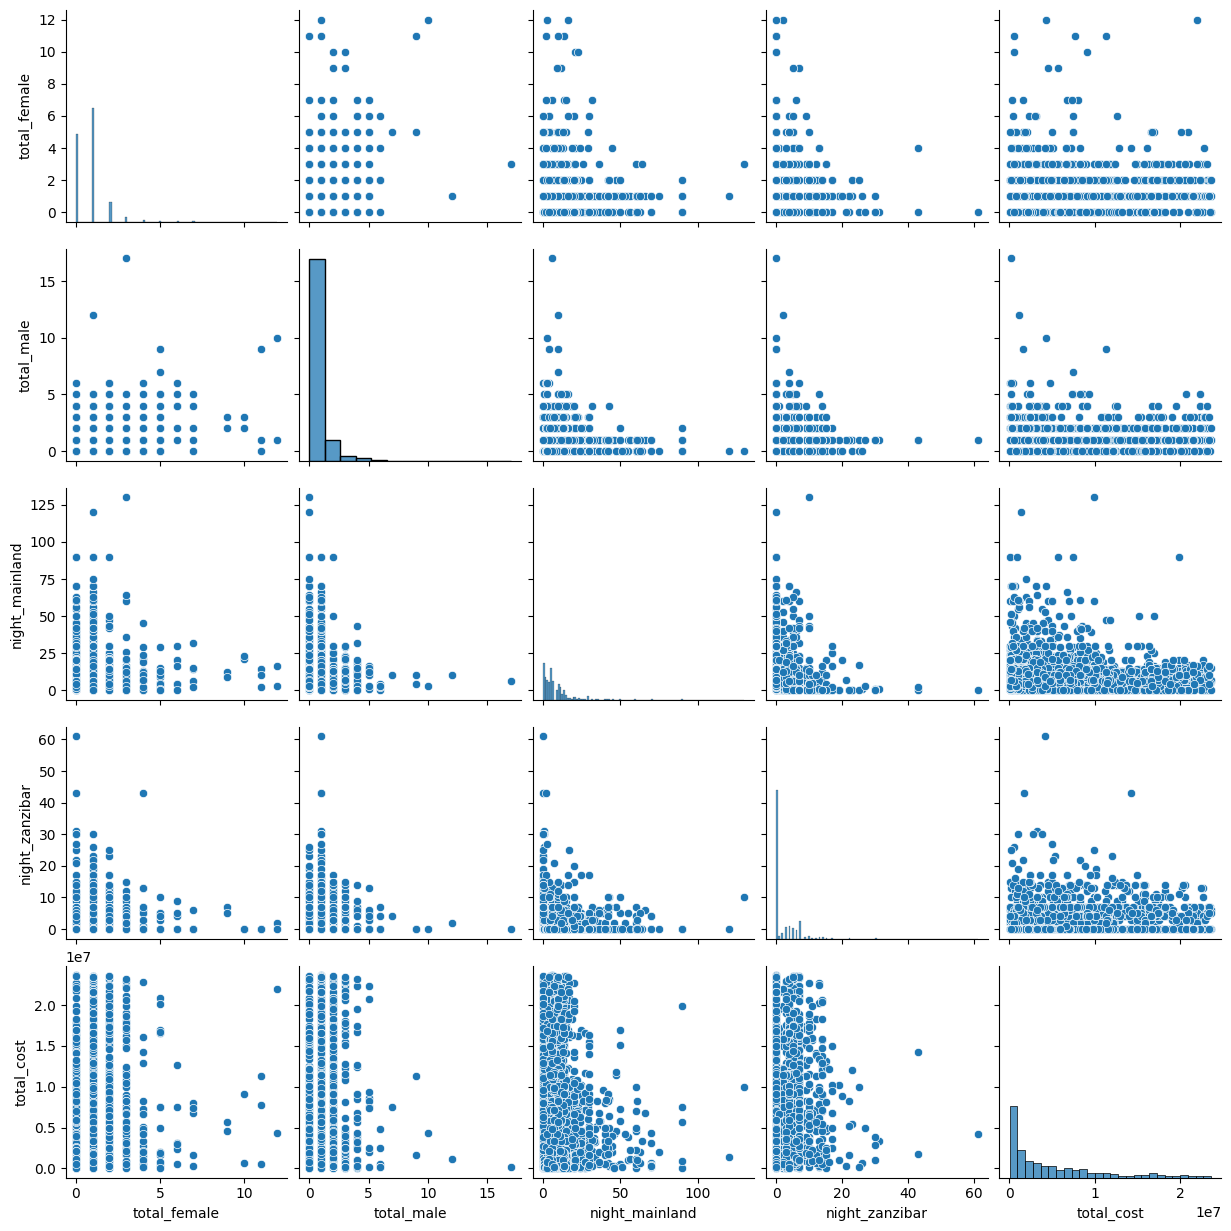

In [48]:
sns.pairplot(df_tanzania_train)

# From these plots we can see that actually there is no strong relation between any of the numerica features and the total_cost

<Axes: >

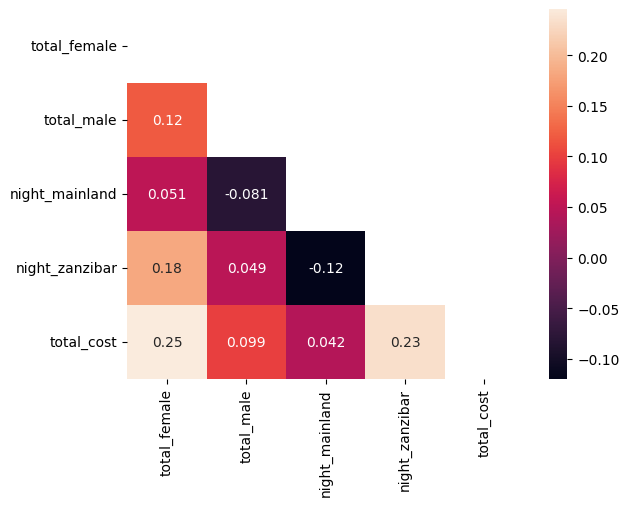

In [49]:
correlations = df_tanzania_train.corr(numeric_only=True)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, annot=True, mask=mask)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Friends/Relatives'),
  Text(1, 0, 'Alone'),
  Text(2, 0, 'Spouse'),
  Text(3, 0, 'Spouse and Children'),
  Text(4, 0, 'Children')])

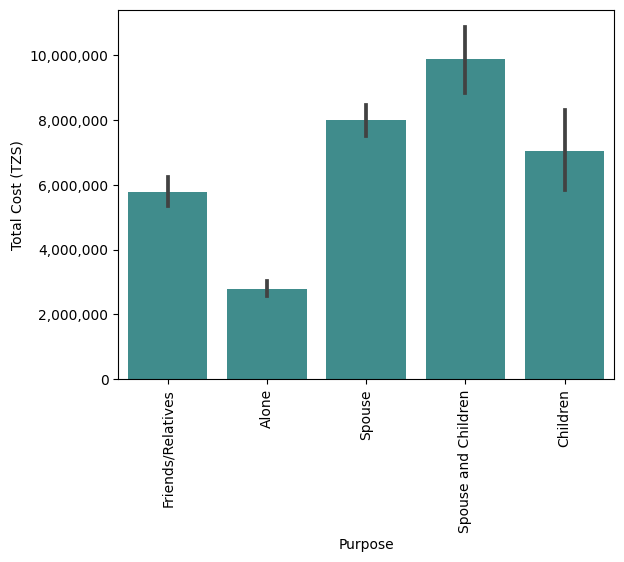

In [50]:
sns.barplot(df_tanzania_train, x= df_tanzania_train["travel_with"], y= df_tanzania_train["total_cost"], color = "teal", alpha=0.8)
# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZS)")
plt.xlabel("Purpose")
plt.xticks(rotation=90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0'),
  Text(5, 0, '5.0'),
  Text(6, 0, '6.0'),
  Text(7, 0, '7.0'),
  Text(8, 0, '9.0'),
  Text(9, 0, '10.0'),
  Text(10, 0, '12.0'),
  Text(11, 0, '17.0')])

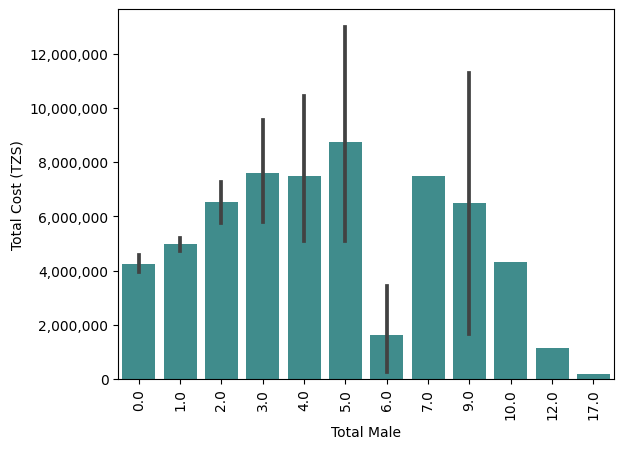

In [51]:
sns.barplot(df_tanzania_train, x= df_tanzania_train["total_male"], y= df_tanzania_train["total_cost"], color = "teal", alpha = 0.8)
# Adding the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Adding label
plt.ylabel("Total Cost (TZS)")
plt.xlabel("Total Male")
plt.xticks(rotation=90)

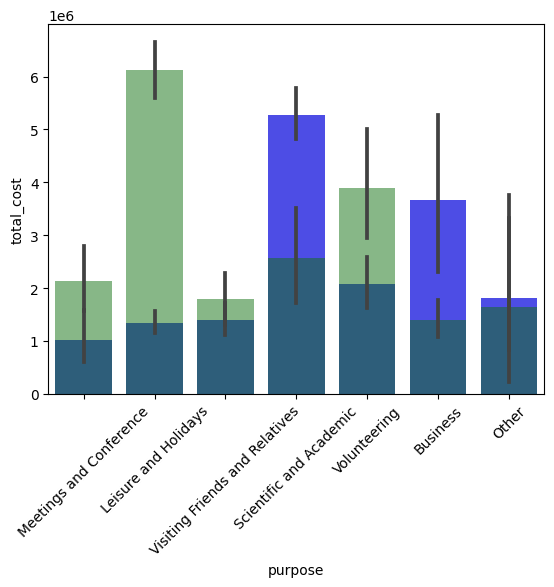

In [52]:
sns.barplot(df_tanzania_train.query("total_female==0"), x="purpose", y="total_cost", color = "blue", alpha=0.8)
sns.barplot(df_tanzania_train.query("total_male==0"), x="purpose", y="total_cost", color = "green", alpha=0.5)
plt.xticks(rotation=45)


plt.show()

# Women spend more money in almost all purposes - except for Business and Meetings & Conferences


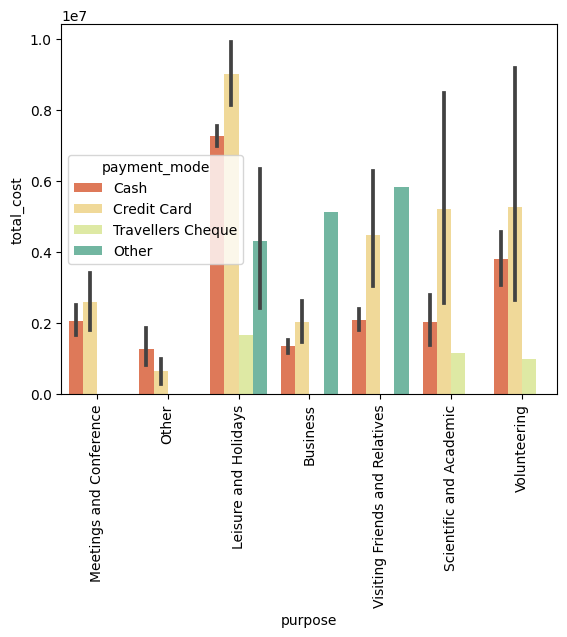

In [53]:
sns.barplot(df_tanzania_train, hue="payment_mode", x="purpose", y="total_cost", palette="Spectral")
plt.xticks(rotation=90)


plt.show()

Text(0.5, 1.0, 'Total Cost by Payment Mode')

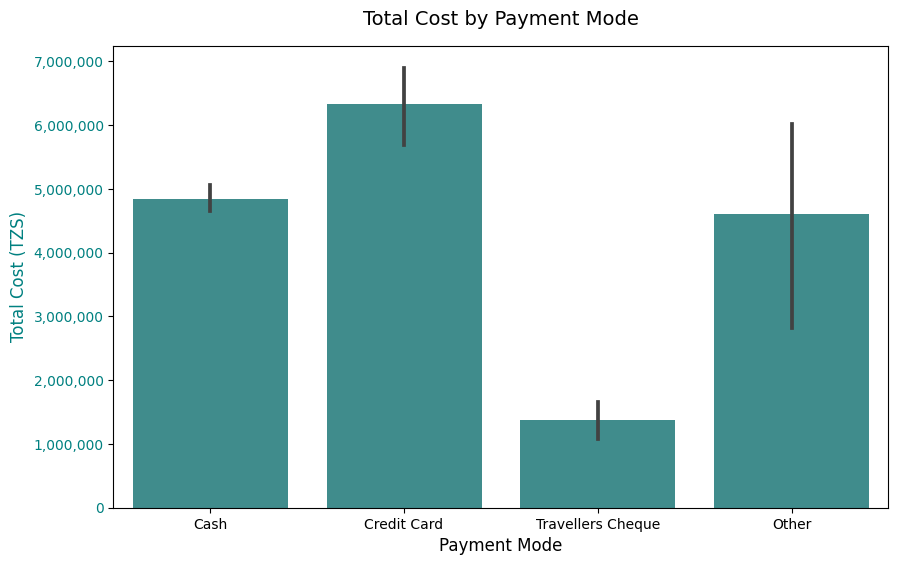

In [54]:

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart for total cost
sns.barplot(x=df_tanzania_train["payment_mode"], y=df_tanzania_train.total_cost, ax=ax1, color="teal", alpha = 0.8)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax1.set_ylabel("Total Cost (TZS)", fontsize=12, color="teal")
ax1.set_xlabel("Payment Mode", fontsize=12)
ax1.tick_params(axis='y', labelcolor="teal")
ax1.tick_params(axis='x', rotation=0)
ax1.set_title("Total Cost by Payment Mode", fontsize=14, pad=15)


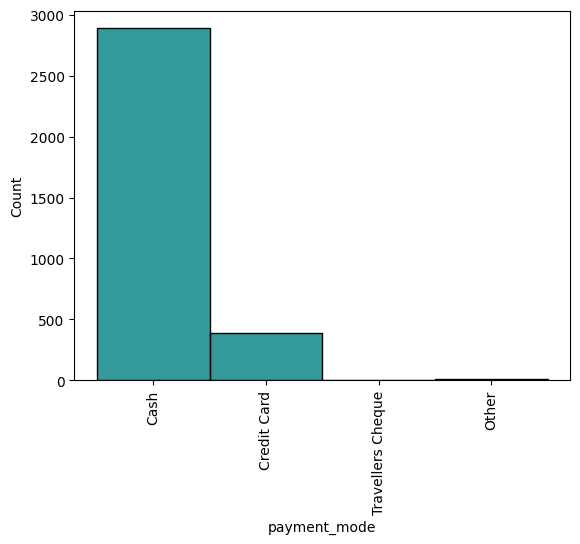

In [55]:
sns.histplot(df_tanzania_train["payment_mode"], color = "teal", alpha = 0.8)
plt.xticks(rotation=90)

plt.show()

# People spend more if they pay with Credit Card

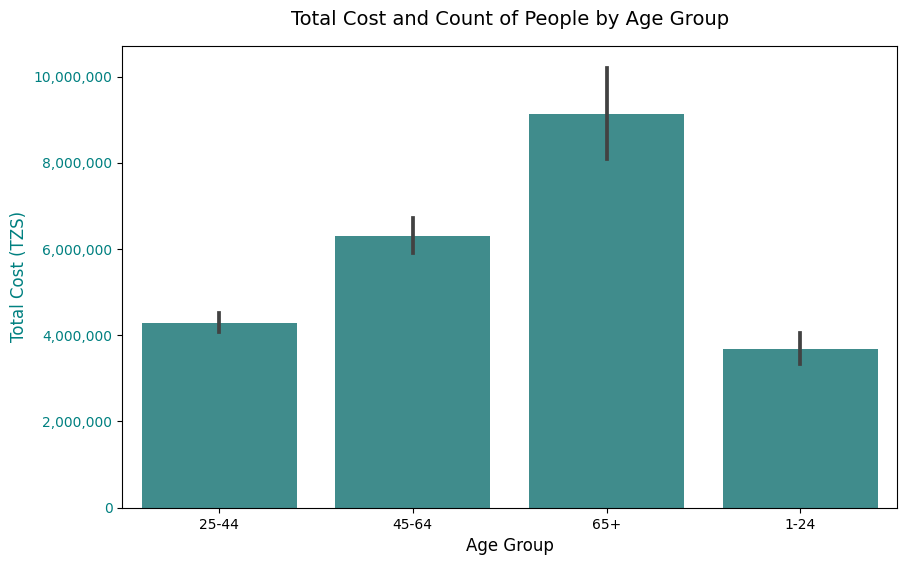

In [56]:
# Group by age_group to calculate total cost and counts
grouped = df_tanzania_train.groupby('age_group').agg(
    total_cost=('total_cost', 'sum'),
    count=('total_cost', 'count')
).reindex(['1-24', '25-44', '45-64', "65+"])  # Ensure custom order

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart for total cost
sns.barplot(x=df_tanzania_train.age_group, y=df_tanzania_train.total_cost, ax=ax1, color="teal", alpha = 0.8)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax1.set_ylabel("Total Cost (TZS)", fontsize=12, color="teal")
ax1.set_xlabel("Age Group", fontsize=12)
ax1.tick_params(axis='y', labelcolor="teal")
ax1.tick_params(axis='x', rotation=0)
ax1.set_title("Total Cost and Count of People by Age Group", fontsize=14, pad=15)


# Show the plot
plt.show()

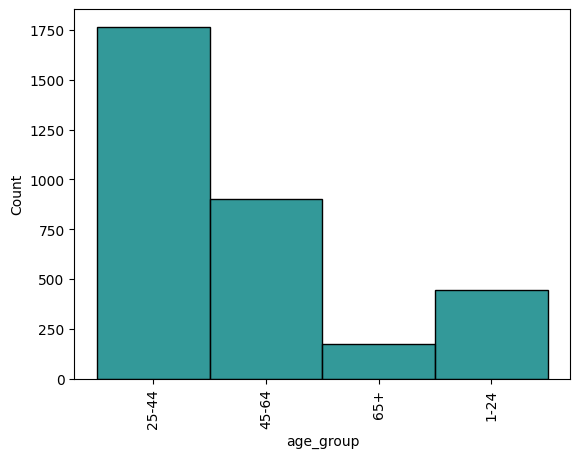

In [57]:
sns.histplot(df_tanzania_train["age_group"], color = "teal", alpha = 0.8)
plt.xticks(rotation=90)

plt.show()

# People spend more if they pay with Credit Card

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Hunting tourism'),
  Text(1, 0, 'business'),
  Text(2, 0, 'Wildlife tourism'),
  Text(3, 0, 'Cultural tourism'),
  Text(4, 0, 'Diving and Sport Fishing'),
  Text(5, 0, 'Beach tourism'),
  Text(6, 0, 'Conference tourism'),
  Text(7, 0, 'Mountain climbing'),
  Text(8, 0, 'Bird watching')])

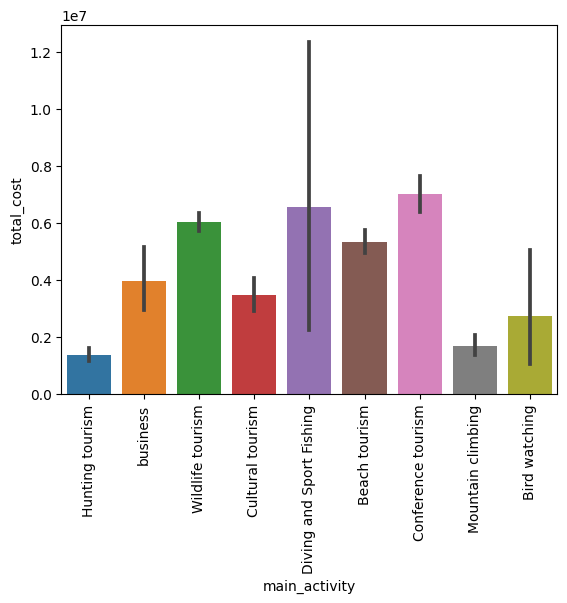

In [58]:
sns.barplot(df_tanzania_train, x="main_activity", y="total_cost")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Meetings and Conference'),
  Text(1, 0, 'Other'),
  Text(2, 0, 'Leisure and Holidays'),
  Text(3, 0, 'Business'),
  Text(4, 0, 'Visiting Friends and Relatives'),
  Text(5, 0, 'Scientific and Academic'),
  Text(6, 0, 'Volunteering')])

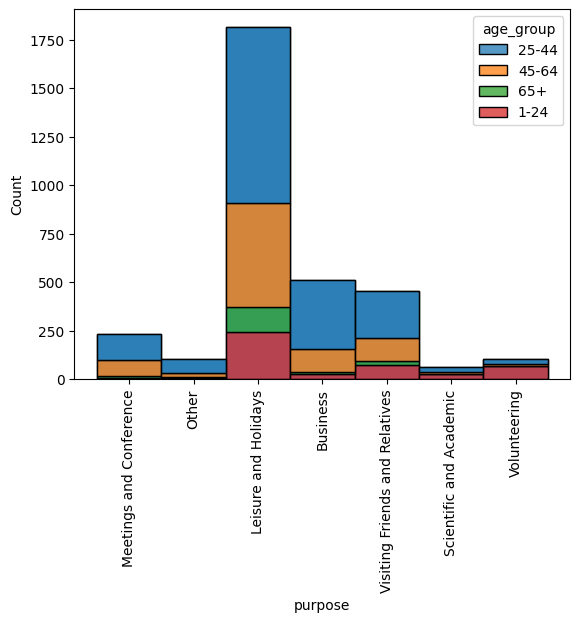

In [59]:
fig, ax = plt.subplots()
sns.histplot(data=df_tanzania_train, x="purpose",ax=ax)
sns.histplot(data=df_tanzania_train, x="purpose", hue="age_group", multiple="stack",ax=ax)
plt.xticks(rotation=90)

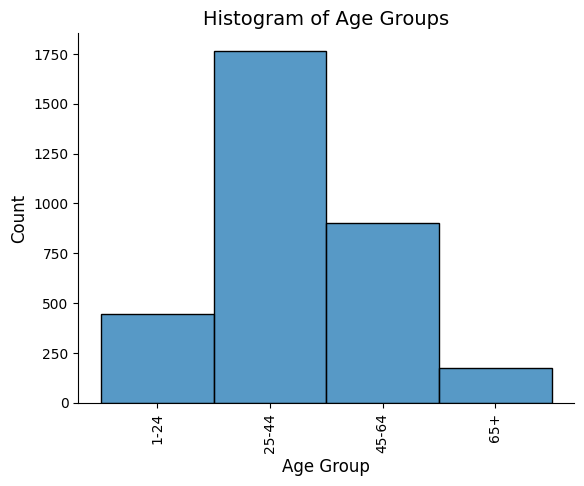

In [60]:
# <Reorganize the age_group and make it categorical

custom_order = ['1-24', '25-44', '45-64', "65+"] 


# Convert 'age_group' into a categorical variable with the custom order
df_tanzania_train['age_group'] = pd.Categorical(
    df_tanzania_train['age_group'], 
    categories=custom_order, 
    ordered=True
)

# Plot the histogram
sns.histplot(data=df_tanzania_train, x='age_group', stat='count', palette="viridis")

# Aesthetics
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Age Groups", fontsize=14)
plt.xticks(rotation=90)
sns.despine()


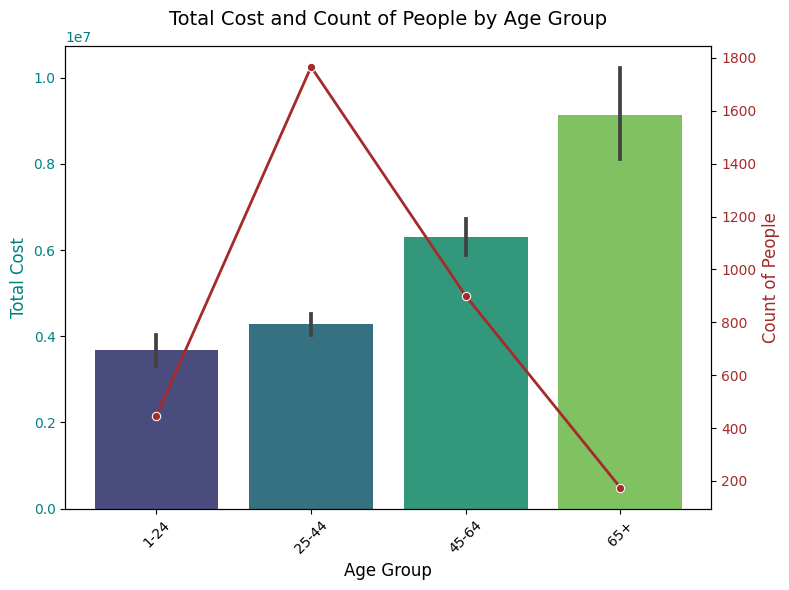

In [61]:
# Group by age_group to calculate total cost and counts
grouped = df_tanzania_train.groupby('age_group').agg(
    total_cost=('total_cost', 'sum'),
    count=('total_cost', 'count')
).reindex(['1-24', '25-44', '45-64', "65+"])  # Ensure custom order

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart for total cost
sns.barplot(x=df_tanzania_train.age_group, y=df_tanzania_train.total_cost, ax=ax1, palette="viridis")
ax1.set_ylabel("Total Cost", fontsize=12, color="teal")
ax1.set_xlabel("Age Group", fontsize=12)
ax1.tick_params(axis='y', labelcolor="teal")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Total Cost and Count of People by Age Group", fontsize=14, pad=15)

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the line chart for the count of people
sns.lineplot(x=grouped.index, y=grouped['count'], ax=ax2, color="brown", marker="o", linewidth=2)
ax2.set_ylabel("Count of People", fontsize=12, color="brown")
ax2.tick_params(axis='y', labelcolor="brown")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Feature Engineering - Train

In [63]:
df_tanzania_train["total_nights"] = df_tanzania_train["night_mainland"] + df_tanzania_train["night_zanzibar"]
df_tanzania_train["total_people"] = df_tanzania_train["total_male"] + df_tanzania_train["total_female"]

In [64]:
# deleted values where total people = 0
df_tanzania_train = df_tanzania_train.query("total_people > 0")

### Imputation

In [65]:
# Impute empty values of "total_female" with rounded mean. 
# Impute empty values of "total_male" with rounded mean. 

df_tanzania_train['total_female'].fillna(round(df_tanzania_train['total_female'].mean()), inplace=True)
df_tanzania_train['total_male'].fillna(round(df_tanzania_train['total_male'].mean()), inplace=True)

In [66]:
# Impute travel_with based on how many people they traveled with. If more than 1 - not alone. 

def travel_with_alone(row):
    travel_alone = row['travel_with']
    male = row['total_male']
    female = row['total_female']
    
    # Only process rows where 'travel_with' is NaN
    if pd.isnull(travel_alone):
        # Check if the person traveled alone
        if male == 1 and female == 0:  # One male, no females
            return "Alone"
        elif male == 0 and female == 1:  # One female, no males
            return "Alone"
        else:  # Any other combination means "Unknown"
            return "Unknown"
    else:
        # Keep the existing value if not NaN
        return travel_alone

In [67]:
# Apply the function to the DataFrame
df_tanzania_train['travel_with'] = df_tanzania_train.apply(travel_with_alone, axis=1)

# Check the number of "Unknown" values
unknown_count = (df_tanzania_train['travel_with'] == 'Unknown').sum()
print(f"Number of 'Unknown' entries: {unknown_count}")

# Check the number of 'Alone' entries for confirmation
alone_count = (df_tanzania_train['travel_with'] == 'Alone').sum()
print(f"Number of 'Alone' entries: {alone_count}")

# Verify that the number of missing values matches the sum of 'Alone' + 'Unknown'
processed_missing_count = unknown_count + alone_count
print(f"Total processed missing values (Alone + Unknown): {processed_missing_count}")

Number of 'Unknown' entries: 20
Number of 'Alone' entries: 1712
Total processed missing values (Alone + Unknown): 1732


### Encoding

In [68]:
#List of columns
col_encode = ['age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement','payment_mode']
col_map = ['package_transport_int', 'package_accomodation', 'package_food','package_transport_tz', 'package_sightseeing', 'package_guided_tour','package_insurance','first_trip_tz',]
col_scale = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']

In [69]:
# Mapp all Yes/No features (col_map)

def mapping_tanzania(df,cols):
    df[cols] = df[cols].replace({'Yes': 1, 'No': 0}) 

mapping_tanzania(df_tanzania_train,col_map)

In [70]:
# Encode all categorical features (col_encode)
categories = [df_tanzania_train[col].unique() for col in col_encode]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_train[col_encode]) 
t = ohe.transform(df_tanzania_train[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_train_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_encode], axis=1)
df_tanzania_train.drop(columns=col_encode,inplace=True)

In [71]:
# Scale all numerical features (col_scale)

scaler = MinMaxScaler()
scaler.fit(df_tanzania_train[col_scale])
t = scaler.transform(df_tanzania_train[col_scale])
df_tanzania_train_scaled = pd.DataFrame(t, columns= scaler.get_feature_names_out())
df_tanzania_train_scaled.head()

# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_scaled], axis=1)
df_tanzania_train.drop(columns=col_scale,inplace=True)

In [169]:
# # Create a scaler for total_cost
# scaler_cost = MinMaxScaler()

# # Fit and transform the total_cost column
# scaled_values = scaler_cost.fit_transform(df_tanzania_train[["total_cost"]])

# # Replace the original total_cost column in the DataFrame with the scaled values
# df_tanzania_train["total_cost"] = scaled_values

In [72]:
df_tanzania_train.shape

(3278, 44)

### Encoding - Pipeline / ColumnTransformer (WiP)

In [171]:
# # Custom transformer for `travel_with`
# class TravelWithTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         # Apply the logic for `travel_with` as described
#         X = X.copy()
#         for index, row in X.iterrows():
#             if pd.isnull(row['travel_with']):
#                 male = row['total_male']
#                 female = row['total_female']
#                 if male == 1 and female == 0:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 elif male == 0 and female == 1:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 else:
#                     X.at[index, 'travel_with'] = 'Unknown'
#         return X[['travel_with']]

#     def get_feature_names_out(self, input_features=None):
#         # Return the output column name for `travel_with`
#         return ['travel_with']

In [172]:
# # Custom imputer transformer to round the mean
# class RoundedMeanImputer(TransformerMixin, BaseEstimator):
#     def fit(self, X, y=None):
#         self.means_ = X.mean().round()
#         return self

#     def transform(self, X):
#         return X.fillna(self.means_)
    
#     def get_feature_names_out(self, input_features=None):
#         # Return the same feature names as the input
#         return input_features

In [173]:
# # ColumnTransformer with RoundedMeanImputer
# preprocessor = ColumnTransformer(
#     transformers=[
#         # Custom imputer for total_female and total_male using rounded mean
#         ('impute_num', RoundedMeanImputer(), ['total_female', 'total_male']),
        
#         # Map Yes/No features to 1/0 directly
#         ('map_binary', OneHotEncoder(drop='if_binary', sparse=False), col_map),

#         # Custom transformer for travel_with
#         ('custom_travel_with', TravelWithTransformer(), ['travel_with', 'total_male', 'total_female']),
        
#         # One-hot encode categorical features
#         ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), col_encode),
        
#         # Scale numerical features
#         ('scale', MinMaxScaler(), col_scale)
#     ],
#     remainder='passthrough'  # Keeps any columns not explicitly listed
# )

# # Full pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor)
# ])


In [174]:
# # Fit and transform the data
# df_processed = pipeline.fit_transform(df_tanzania_train)

# # Convert to DataFrame
# output_columns = pipeline.named_steps['preprocessor'].get_feature_names_out()
# df_processed = pd.DataFrame(df_processed, columns=output_columns)

# # Verify results
# print("Shape of processed DataFrame:", df_processed.shape)
# print("Remaining NaN values:", df_processed.isna().sum().sum())

## Feature Engineering - Test

In [73]:
df_tanzania_test = X_test.join(y_test)

In [74]:
# Add new columns

df_tanzania_test["total_nights"] = df_tanzania_test["night_mainland"] + df_tanzania_test["night_zanzibar"]
df_tanzania_test["total_people"] = df_tanzania_test["total_male"] + df_tanzania_test["total_female"]

# deleted values where total people = 0
df_tanzania_test = df_tanzania_test.query("total_people > 0")

### Imputation

In [75]:
# Impute empty values of "total_female" with rounded mean. 
# Impute empty values of "total_male" with rounded mean. 
# 
df_tanzania_test['total_female'].fillna(round(df_tanzania_test['total_female'].mean()), inplace=True)
df_tanzania_test['total_male'].fillna(round(df_tanzania_test['total_male'].mean()), inplace=True)

In [77]:
# Apply the function to the DataFrame
df_tanzania_test['travel_with'] = df_tanzania_test.apply(travel_with_alone, axis=1)


### Encoding

In [78]:
mapping_tanzania(df_tanzania_test,col_map)

In [79]:
# Encode all categorical features (col_encode)

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', categories=categories)
ohe.fit(df_tanzania_test[col_encode]) 
t = ohe.transform(df_tanzania_test[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_test_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_test = pd.concat([df_tanzania_test.reset_index(drop=True), df_tanzania_test_encode], axis=1)
df_tanzania_test.drop(columns=col_encode,inplace=True)

In [80]:
# Scale all numerical features (col_scale)

scaler = MinMaxScaler()
scaler.fit(df_tanzania_test[col_scale])
t = scaler.transform(df_tanzania_test[col_scale])
df_tanzania_test_scaled = pd.DataFrame(t, columns= scaler.get_feature_names_out())
df_tanzania_test_scaled.head()

# introduced into the frame
df_tanzania_test = pd.concat([df_tanzania_test.reset_index(drop=True), df_tanzania_test_scaled], axis=1)
df_tanzania_test.drop(columns=col_scale,inplace=True)

In [182]:
# # Create a scaler for total_cost
# scaler_cost = MinMaxScaler()

# # Fit and transform the total_cost column
# scaled_values = scaler_cost.fit_transform(df_tanzania_test[["total_cost"]])

# # Replace the original total_cost column in the DataFrame with the scaled values
# df_tanzania_test["total_cost"] = scaled_values

In [81]:
df_tanzania_train.shape

(3278, 44)

In [82]:
df_tanzania_test.shape

(1092, 44)

## Baseline Model: Decision Tree

In [84]:
X_train_b = df_tanzania_train.drop("total_cost", axis=1)
y_train_b = df_tanzania_train["total_cost"]
X_test_b = df_tanzania_test.drop("total_cost", axis=1)
y_test_b = df_tanzania_test["total_cost"]

In [85]:
# Define a function to calculate metrics

def evaluate_model(title, model, X_test, y_test):
    """
    Evaluate a model on the test set and print the evaluation metrics.

    Parameters:
        model_name (str): The name of the model to display in the title.
        model: The trained model to evaluate.
        X_test: Test features.
        y_test: True labels for the test set.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics with a title
    print(f"{title} {model}:")
    print(f" - Mean Squared Error (MSE): {mse}")
    print(f" - Root Mean Squared Error (RMSE): {rmse}")
    print(f" - Mean Absolute Error (MAE): {mae}")
    print(f" - R-squared (R²): {r2}\n")

In [86]:
# Define a function to plot actual vs predicted cost
def plot_model_results(model_name, model, y_train, y_pred):
    plt.figure(figsize=(7, 5))
    plt.scatter(y_train, y_pred, color='teal', alpha=0.5)
    plt.plot([0, df_tanzania_train["total_cost"].max()], [0, df_tanzania_train["total_cost"].max()], color='brown', linestyle='--')  # line of perfect predictions (45-degree line)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.xlabel('Actual Values (Cost in TZN)')
    plt.ylabel('Actual Values (Cost in TZN)')
    plt.title(f'Predicted vs Actual Values: {model_name}')
    plt.show()

In [87]:
# # Initialize baseline model Regressor
baseline = DecisionTreeRegressor(max_features=2, random_state=RSEED)
baseline.fit(X_train_b, y_train_b)


DecisionTreeRegressor(max_features=2, random_state=42)

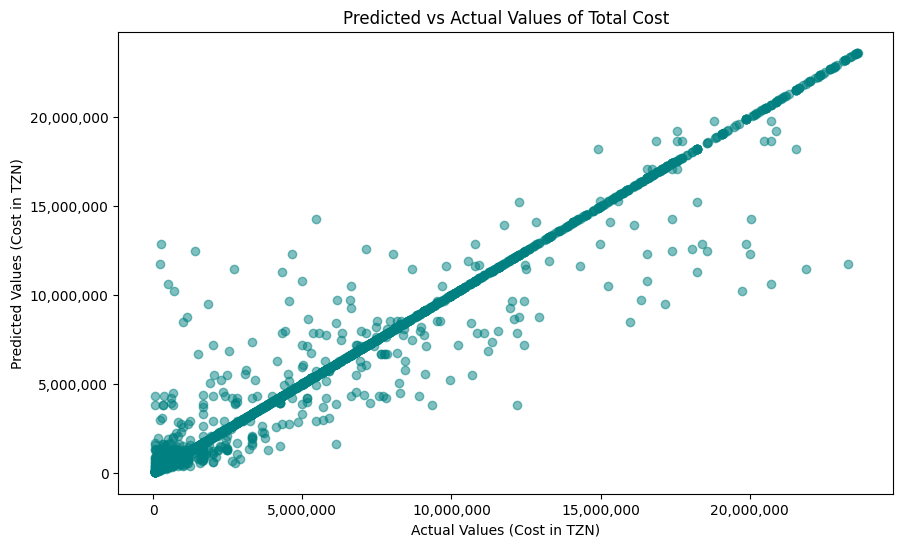

In [88]:
# Actual values
y_pred = baseline.predict(X_train_b)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_train_b, y_pred, color='teal', alpha=0.5)
plt.plot([0, 1], [0, 1], color='brown', linestyle='--')  # line of perfect predictions (45-degree line)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.xlabel('Actual Values (Cost in TZN)')
plt.ylabel('Predicted Values (Cost in TZN)')
plt.title('Predicted vs Actual Values of Total Cost')
plt.show()

In [91]:
evaluate_model("Train",baseline, X_train_b, y_train_b)
evaluate_model("Test",baseline, X_test_b, y_test_b)

Train DecisionTreeRegressor(max_features=2, random_state=42):
 - Mean Squared Error (MSE): 1054689568714.1954
 - Root Mean Squared Error (RMSE): 1026980.8025051858
 - Mean Absolute Error (MAE): 253658.14459673548
 - R-squared (R²): 0.9664305930556033

Test DecisionTreeRegressor(max_features=2, random_state=42):
 - Mean Squared Error (MSE): 27426347121452.6
 - Root Mean Squared Error (RMSE): 5237017.006030494
 - Mean Absolute Error (MAE): 3388514.0865950854
 - R-squared (R²): 0.14576318467236338

